In [1]:
!pip install imbalanced-learn


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from imblearn.over_sampling import SMOTE


In [15]:
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


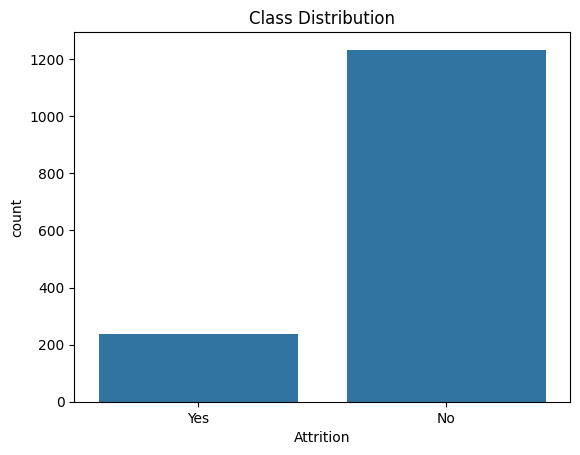

Attrition
No     1233
Yes     237
Name: count, dtype: int64


In [16]:
sns.countplot(x="Attrition", data=df)
plt.title("Class Distribution")
plt.show()

print(df["Attrition"].value_counts())


In [17]:
if "EmployeeNumber" in df.columns:
    df = df.drop("EmployeeNumber", axis=1)


In [18]:
label_encoders = {}

for column in df.select_dtypes(include=["object", "string"]).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le


In [19]:
X = df.drop("Attrition", axis=1)
y = df["Attrition"]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [21]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

print("After SMOTE class distribution:")
print(pd.Series(y_train).value_counts())


After SMOTE class distribution:
Attrition
0    986
1    986
Name: count, dtype: int64


In [22]:
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [23]:
y_probs = model.predict_proba(X_test)[:, 1]


In [27]:
best_threshold = 0.5
best_precision = 0

for t in np.arange(0.3, 0.95, 0.05):
    temp_pred = (y_probs > t).astype(int)
    report = classification_report(y_test, temp_pred, output_dict=True)
    precision_1 = report["1"]["precision"]

    if precision_1 > best_precision:
        best_precision = precision_1
        best_threshold = t

print("Best Threshold:", best_threshold)
print("Best Precision:", best_precision)

y_pred = (y_probs > best_threshold).astype(int)


Best Threshold: 0.7499999999999999
Best Precision: 0.6


In [28]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.8469387755102041

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       247
           1       0.60      0.13      0.21        47

    accuracy                           0.85       294
   macro avg       0.73      0.56      0.56       294
weighted avg       0.81      0.85      0.80       294



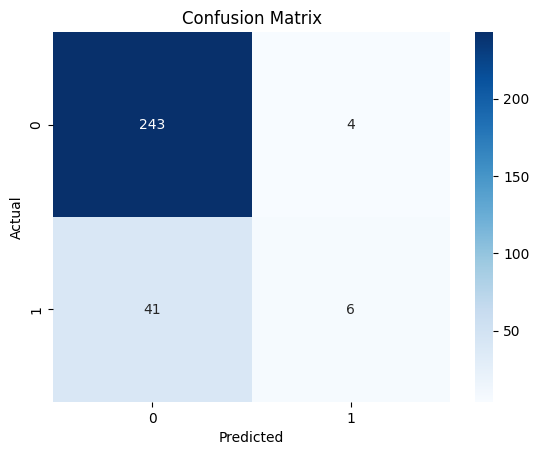

In [29]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

